In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pylab 

In [2]:
## https://jonchar.net/notebooks/matplotlib-styling/
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

In [3]:

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [4]:
def stylize_axes(ax, title, xlabel, ylabel):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [5]:
import re
def get_data(root_folder):
    file_name = "policy_log"
    
    list_real = []
    with open('%s/%s.txt' % (root_folder, file_name), 'r') as f:
        for line in f:
            ls = line.strip()
            match = re.search(r'iter (\d+) \[(.*)\] \[(.*)\]', ls)

            if match:
                iter, val, real = match.group(1), match.group(2), match.group(3)

            final_real = float(real.split(",")[-1])
            list_real.append(final_real)
            
    return list_real

In [6]:
def plot_ax_data(ax, root_folder, n_datapoint, color, linestyle, label):
    
    list_reals = []
    min_idx = 500
    for f in root_folder:
        list_real = -np.array(get_data(f))
        list_reals.append(list_real)
        
        if min_idx > len(list_real):
            min_idx = len(list_real)
        
    arr_costs = np.array([real[:min_idx] for real in list_reals])
    cost_mean = np.mean(arr_costs, axis=0)
    cost_std  = np.std(arr_costs, axis=0)

    ts = np.arange(n_datapoint, (len(cost_mean)+1)*n_datapoint, n_datapoint)
    hand = ax.plot(ts, cost_mean, color, linestyle=linestyle, label=label)
    ax.fill_between(ts, cost_mean-cost_std, cost_mean+cost_std, color=color, linestyle=linestyle, alpha=0.1)
    
    return ax, hand

In [7]:
import pandas as pd
import glob

In [8]:
def get_mf_data(root_folder):
           
    file_name = "progress"
    df = pd.read_csv('%s/%s.csv' % (root_folder, file_name))
    list_real = (-df["AverageReturn"]).tolist()
            
    return list_real

In [9]:
def plot_mf_data(ax, root_folder, n_datapoint, color, linestyle, label):
    
    list_reals = []
    min_idx = 500
    for f in root_folder:
        list_real = -np.array(get_mf_data(f))
        list_reals.append(list_real)
        
        if min_idx > len(list_real):
            min_idx = len(list_real)
        
    arr_costs = np.array([real[:min_idx] for real in list_reals])
    cost_mean = np.mean(arr_costs, axis=0)
    cost_std  = np.std(arr_costs, axis=0)

    ts = np.arange(n_datapoint, (len(cost_mean)+1)*n_datapoint, n_datapoint)
    hand = ax.plot(ts, cost_mean, color, linestyle=linestyle, label=label)
    ax.fill_between(ts, cost_mean-cost_std, cost_mean+cost_std, color=color, linestyle=linestyle, alpha=0.1)
    
    return ax, hand

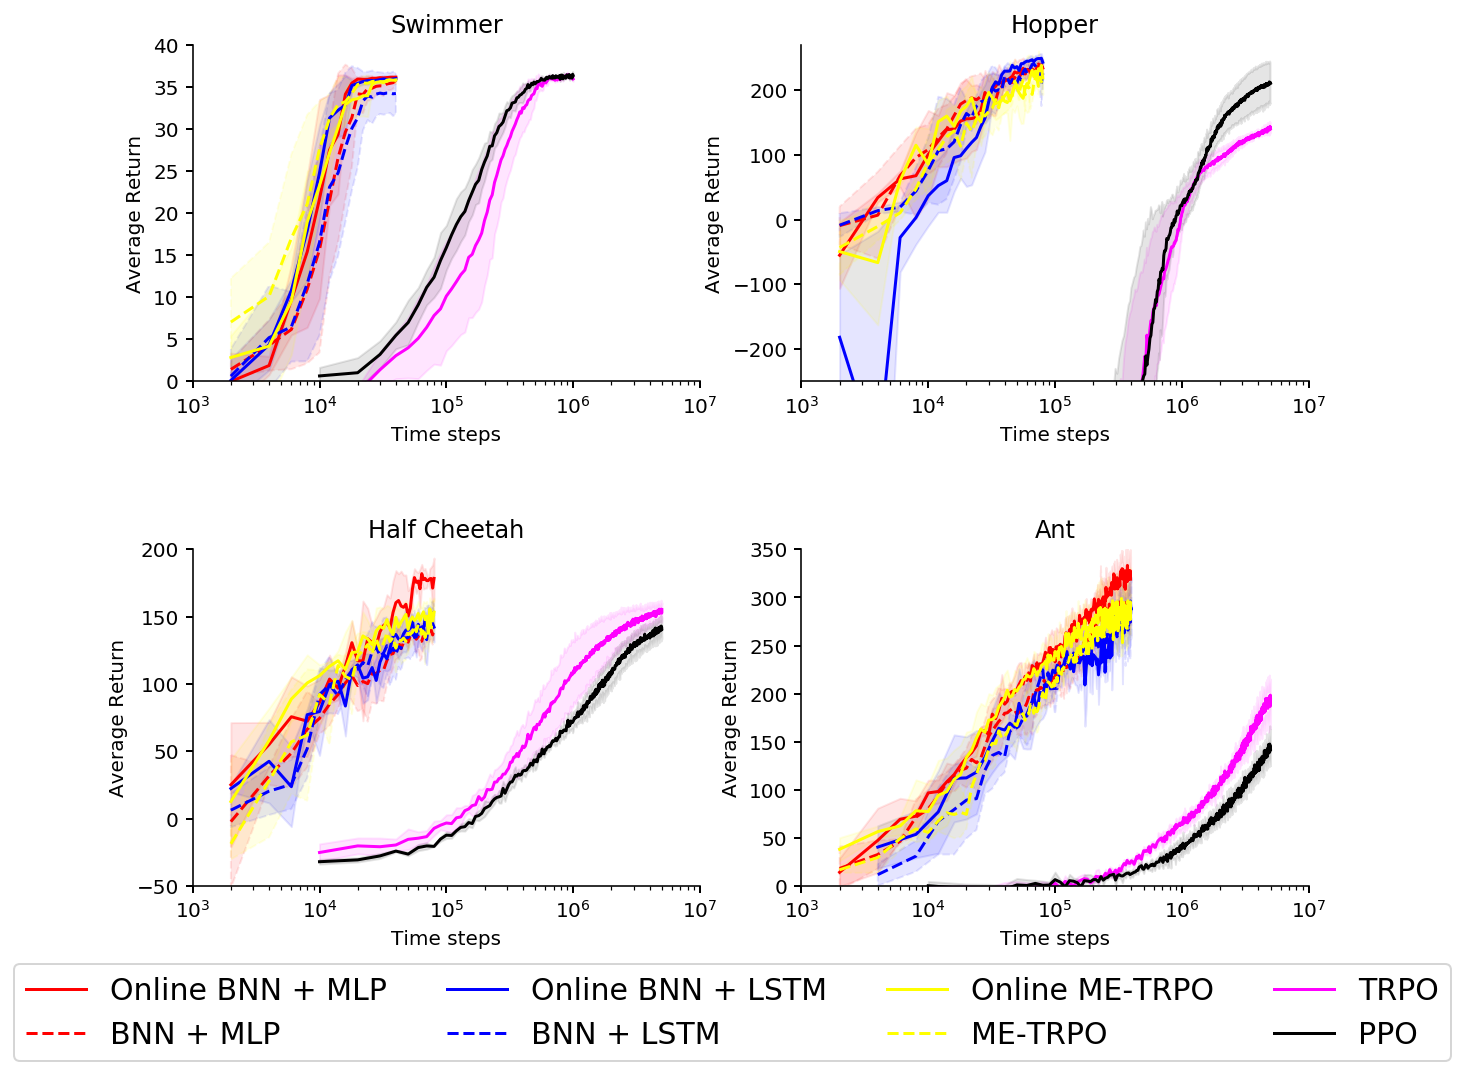

In [14]:
all_folders = []

envs = ["swimmer" ,"hopper", "half_cheetah", "ant"]
names = ["Swimmer", "Hopper", "Half Cheetah", "Ant"]

mb_n_datapoints = {"swimmer": [2000 for _ in range(6)],
               "hopper": [2000 for _ in range(6)],
               "half_cheetah": [2000 for _ in range(6)],
               "ant": [2000, 2000, 4000, 4000, 2000, 2000]}

mf_n_datapoints = {"swimmer": [10000 for _ in range(2)],
               "hopper": [10000 for _ in range(2)],
               "half_cheetah": [10000 for _ in range(2)],
               "ant": [10000, 10000]}

min_rewards = [0, -250, -50, 0]
max_rewards = [40, 270, 200, 350]

mb_root = "../results/nips/forward"
mf_root = "/home/thobotics/rllab/data"
   
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# fig.tight_layout()

i = 0

for env, name, min_reward, max_reward in zip(envs, names, min_rewards, max_rewards):
    
    x = int(i / 2)
    y = i % 2

    handles = []

    colors = ['r', 'r', 'blue', 'blue', 'yellow', 'yellow']
    linestyles = ['-', '--', '-', '--', '-', '--']
    mb_labels = ["Online BNN + MLP", "BNN + MLP", "Online BNN + LSTM", "BNN + LSTM", "Online ME-TRPO", "ME-TRPO"]
    models = ["continual_bnn_trpo_con_vs_nonc", "non_continual_bnn_trpo_con_vs_nonc", 
              "continual_bnn_trpo_con_vs_nonc", "non_continual_bnn_trpo_con_vs_nonc",
              "continual_me_trpo_con_vs_nonc", "non_continual_me_trpo_con_vs_nonc"]
    policy = ["", "", "_lstm", "_lstm", "", ""]
    n_datapoints = mb_n_datapoints[env]
    
    for p, m, c, ls, l, ndata in zip(policy, models, colors, linestyles, mb_labels, n_datapoints):
        root_folder = ["%s/%s%s/%s/%d" % (mb_root, env, p, m, i) for i in [0, 1, 2]]
        all_folders += root_folder
        _, hand = plot_ax_data(ax[x, y], root_folder, ndata, c, ls, l)
        handles.append(hand[0])

    colors = ['magenta', 'black']
    linestyles = ['-', '-']
    mf_labels = ["TRPO", "PPO"]
    mfs = ["trpo", "ppo"]
    n_datapoints = mf_n_datapoints[env]
    
    for m, c, ls, l, ndata in zip(mfs, colors, linestyles, mf_labels, n_datapoints):
        root_folder = [f for f in glob.glob('%s/%s/%s/experiment*' % (mf_root, env, m), recursive=True)]
        all_folders += root_folder
        _, hand = plot_mf_data(ax[x, y], root_folder, ndata, c, ls, l)
        handles.append(hand[0])
        
    ax[x, y].set_xscale('log', basex=10)
    ax[x, y].set_xticks([10**i for i in range(3, 8)])
    ax[x, y].set_ylim(min_reward, max_reward)
    stylize_axes(ax[x, y], name, "Time steps", "Average Return")
        
    i += 1
        
# ax.legend(handles, labels, bbox_to_anchor=(0.01, 0), loc = 'lower right')
fig.legend(handles,     # The line objects
           mb_labels + mf_labels,   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.2,    # Small spacing around legend box
           ncol=4,
           prop={'size': 15}
           )

pylab.subplots_adjust(bottom=0.15, hspace=0.5)

fig.savefig("%s/mb_mf_comparison.png" % ("../results/nips"), dpi=800, bbox_inches='tight')